In [ ]:
# Downloading Dataset (Google Colab Environment)
! wget "https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz"
! tar -xzf "/content/domain_sentiment_data.tar.gz"

--2022-06-02 12:22:18--  https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz
Resolving www.cs.jhu.edu (www.cs.jhu.edu)... 128.220.13.64
Connecting to www.cs.jhu.edu (www.cs.jhu.edu)|128.220.13.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30586147 (29M) [application/x-gzip]
Saving to: ‘domain_sentiment_data.tar.gz’

domain_sentiment_da 100%[===================>]  29.17M  20.0MB/s    in 1.5s    

2022-06-02 12:22:20 (20.0 MB/s) - ‘domain_sentiment_data.tar.gz’ saved [30586147/30586147]



In [ ]:
import os
import numpy as np

import matplotlib.pyplot as plt
import re
from pickle import dump
from pickle import load

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import gensim
import gensim.downloader as api

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense, Embedding, TimeDistributed
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
def clean_sentence(sentence: str) -> list:
  # Remove the review tag
  tags = re.compile("(<review_text>|<\/review_text>)")
  sentence = re.sub(tags, '', sentence)

  # lower case
  sentence = sentence.lower()

  # Remove emails and urls
  email_urls = re.compile("(\bhttp.+? | \b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b)")
  sentence = re.sub(email_urls, '', sentence)

  # Some used '@' to hide offensive words (bla -> bl@)
  ats = re.compile('@')
  sentence = re.sub(ats, 'a', sentence)

  # Remove Punctuation 
  # punc = re.compile("[!\"\#\$\%\&\'\(\)\*\+,\-\.\/\:;<=>\?\[\\\]\^_`\{\|\}\~]")
  punc = re.compile("[^\w\s(\w+\-\w+)]")
  sentence = re.sub(punc, '', sentence)

  # Remove stopwords and tokenize
  # sentence = sentence.split(sep=' ')
  sentence = word_tokenize(sentence)
  sentence = [word for word in sentence if not word in stopwords.words()]

  # Stemming (Returning to root)
  # stemmer = PorterStemmer()
  # sentence = [stemmer.stem(word) for word in sentence]


  return sentence

In [ ]:
# Read files
path = "/content/sorted_data_acl/"
regex_review = re.compile("<review_text>.+?<\/review_text>", flags=re.DOTALL)

# Training Data
folders = ["books","dvd","electronics"]
x_train = list()
y_train = list()
print('Reading Train Data')
for folder in folders:
  temp = open(path+folder+"/negative.review", 'r').read() # Read the file
  temp = re.findall(regex_review, temp) # Get reviews
  print("Reading",len(temp),"Negative reviews from",folder)
  for sentence in temp:
    x_train.append(clean_sentence(sentence))
    y_train.append(0)
  

  temp = open(path+folder+"/positive.review", 'r').read() # Read the file
  temp = re.findall(regex_review, temp) # Get reviews
  print("Reading",len(temp),"Positive reviews from",folder)
  for sentence in temp:
    x_train.append(clean_sentence(sentence))
    y_train.append(1)
  


# Test data
folders = ["kitchen_&_housewares"]
x_test = list()
y_test = list()
print('Reading Test Data')
for folder in folders:
  temp = open(path+folder+"/negative.review", 'r').read() # Read the file
  temp = re.findall(regex_review, temp) # Get reviews
  print("Reading",len(temp),"Negative reviews from",folder)
  for sentence in temp:
    x_test.append(clean_sentence(sentence))
    y_test.append(0)
  

  temp = open(path+folder+"/positive.review", 'r').read() # Read the file
  temp = re.findall(regex_review, temp) # Get reviews
  print("Reading",len(temp),"Positive reviews from",folder)
  for sentence in temp:
    x_test.append(clean_sentence(sentence))
    y_test.append(1)
  



Reading Train Data
Reading 1000 Negative reviews from books
Reading 1000 Positive reviews from books
Reading 1000 Negative reviews from dvd
Reading 1000 Positive reviews from dvd
Reading 1000 Negative reviews from electronics
Reading 1000 Positive reviews from electronics
Reading Test Data
Reading 1000 Negative reviews from kitchen_&_housewares
Reading 1000 Positive reviews from kitchen_&_housewares


In [ ]:
# It took more than one hour, saving them (T_T)

temp_file = open('x_train','wb')
save_x_train = dump(x_train, temp_file)
temp_file.close()

temp_file = open('y_train','wb')
save_y_train = dump(y_train, temp_file)
temp_file.close()

temp_file = open('x_test','wb')
save_x_test = dump(x_test, temp_file)
temp_file.close()

temp_file = open('y_test','wb')
save_y_test = dump(y_test, temp_file)
temp_file.close()


# Loading them

# temp_file = open('x_train', 'rb')
# x_train = load(temp_file)
# temp_file.close()

# temp_file = open('y_train', 'rb')
# y_train = load(temp_file)
# temp_file.close()

# temp_file = open('x_test', 'rb')
# x_test = load(temp_file)
# temp_file.close()

# temp_file = open('y_test', 'rb')
# y_test = load(temp_file)
# temp_file.close()

Max size: 1942
Min size: 1
Top 10 sizes: [586, 589, 591, 596, 597, 599, 622, 631, 643, 674, 674, 678, 703, 711, 711, 750, 752, 822, 1196, 1942]
From  0 to 20 : 955.0
From  20 to 40 : 1422.0
From  40 to 60 : 1121.0
From  60 to 80 : 657.0
From  80 to 100 : 459.0
From  100 to 120 : 305.0
From  120 to 140 : 237.0
From  140 to 160 : 152.0
From  160 to 180 : 112.0
From  180 to 200 : 112.0
From  200 to 300 : 302.0


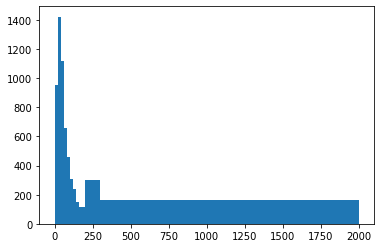

In [ ]:
# Some investigations
lengths = [len(sentence) for sentence in x_train]
lengths.sort()
print("Max size:", max(lengths))
print("Min size:", min(lengths))
print("Top 10 sizes:",lengths[-20:])
counts,bins,_ = plt.hist(lengths,bins=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300, 2000])
for i in range(len(counts)-1):
  print('From ',bins[i],'to',bins[i+1],':',counts[i])

plt.show()

# Most reviews are less than 100 words (4614), and 918 reviews are less than 200 but greater than 100
# Lets take max sequence length as 125 (using weighted mean and neglecting reviews above 300 words)
# or 175 if we took all review sizes into consideration

In [ ]:
# Get the vocab
vocab = set()
for sentence in x_train:
  for word in sentence:
    vocab.add(word)

vocab.add('') # for dummy words, to avoid adding a word that has a meaning
print("Vocab size:", len(vocab))

# Make a mapping betwween words and their IDs
word2id = {word:id for  id, word in enumerate(vocab)}
id2word = {id:word for  id, word in enumerate(vocab)}

Vocab size: 42968


In [ ]:
def encode_sentence(old_sentence):
  encoded_sentence = []
  dummy = word2id['']
  for word in old_sentence:
    try:
      encoded_sentence.append(word2id[word])
    except KeyError:
      encoded_sentence.append(dummy) # the none char

  return encoded_sentence

In [ ]:
# Encoding train sentences
x_train_encoded = []
for sentence in x_train:
  x_train_encoded.append(encode_sentence(sentence))

# Encoding test sentences
x_test_encoded = []
for sentence in x_test:
  x_test_encoded.append(encode_sentence(sentence))

print("Len train:", len(x_train_encoded))
print("Len test:", len(x_test_encoded))

Len train: 6000
Len test: 2000


In [ ]:
MAX_SEQ_LEN = 125
dummy = word2id['']
# Padding train sentences
x_train_padded = pad_sequences(x_train_encoded, maxlen=MAX_SEQ_LEN, dtype='int', padding='post', truncating='post', value=dummy)
print("Train shape: ",x_train_padded.shape)

# Padding test sentences
x_test_padded = pad_sequences(x_test_encoded, maxlen=MAX_SEQ_LEN, dtype='int', padding='post', truncating='post', value=dummy)
print("Test shape: ", x_test_padded.shape)

Train shape:  (6000, 125)
Test shape:  (2000, 125)


In [ ]:
# Changing labels type and shape for training
y_train = np.array(y_train)
temp, = y_train.shape
y_train = y_train.reshape((temp,1))
y_train.shape

y_test = np.array(y_test)
temp, = y_test.shape
y_test = y_test.reshape((temp,1))
y_test.shape

(2000, 1)

In [ ]:
# Loading the Word2Vec Model
# glove-twitter-200 model was trained on 2B tweets
# with a 1.2M vocab size
w2v = api.load('glove-twitter-200')
w2v.most_similar("mahmoud")

[('mohamed', 0.7128403186798096),
 ('mostafa', 0.6895012259483337),
 ('ahmed', 0.6817302703857422),
 ('mohey', 0.6513986587524414),
 ('ahmadinejad', 0.6093316674232483),
 ('mohammed', 0.5743428468704224),
 ('youssef', 0.5647962689399719),
 ('morsi', 0.554459810256958),
 ('hassan', 0.5542215704917908),
 ('fouad', 0.5403571724891663)]

In [ ]:
# Create an embedding matrix for the embedding layer
num_words = len(vocab)
embed_size, = w2v['mahmoud'].shape
embedding_matrix = np.zeros(shape=(num_words, embed_size))

for word, id in word2id.items():
  try:
    embedding_matrix[id] = w2v[word]
  except KeyError:
    embedding_matrix[id] = np.zeros(embed_size)

embedding_matrix.shape

(42968, 200)

In [ ]:
tf.keras.backend.clear_session() # Makes sure old model was deleted if exists

# create model
lstm_model = Sequential(name='Rating')

lstm_model.add(Input(shape=(MAX_SEQ_LEN,), dtype='int32'))
lstm_model.add(Embedding(input_dim = len(vocab),            # Vocabulary Size (number of unique words for training)
                        output_dim = embed_size,            # Length of the vector for each word (embedding dimension)
                        input_length = MAX_SEQ_LEN,         # Maximum length of a sequence
                        weights = [embedding_matrix],       # Send the needed glove-twitter-200 Weights
                        trainable = False))

lstm_model.add(LSTM(units = 30, 
                    return_sequences=True, 
                    # dropout=0.5, 
                    # recurrent_dropout=0.5
                    )
              )
lstm_model.add(LSTM(units = 30, 
                    # return_sequences=True,
                    # dropout=0.5, 
                    # recurrent_dropout=0.5
                    )
              )
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999), 
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
lstm_model.summary()

Model: "Rating"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 125, 200)          8593600   
                                                                 
 lstm (LSTM)                 (None, 125, 30)           27720     
                                                                 
 lstm_1 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 8,628,671
Trainable params: 35,071
Non-trainable params: 8,593,600
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
train_data, train_labels = shuffle(x_train_padded, y_train, random_state=42)

In [ ]:
lstm_model.save('lstm_w_770.h5',save_format='h5')

In [ ]:
lstm_model.fit(train_data, 
               train_labels, 
               validation_split=0.20, 
               batch_size = 50,
               epochs = 50)

Epoch 1/50
96/96 [==============================] - 10s 80ms/step - loss: 0.6919 - accuracy: 0.5194 - val_loss: 0.6904 - val_accuracy: 0.5275
Epoch 2/50
96/96 [==============================] - 7s 74ms/step - loss: 0.6904 - accuracy: 0.5312 - val_loss: 0.6895 - val_accuracy: 0.5292
Epoch 3/50
96/96 [==============================] - 7s 74ms/step - loss: 0.6886 - accuracy: 0.5360 - val_loss: 0.6886 - val_accuracy: 0.5333
Epoch 4/50
96/96 [==============================] - 7s 75ms/step - loss: 0.6857 - accuracy: 0.5417 - val_loss: 0.6872 - val_accuracy: 0.5325
Epoch 5/50
96/96 [==============================] - 7s 75ms/step - loss: 0.6804 - accuracy: 0.5475 - val_loss: 0.6860 - val_accuracy: 0.5308
Epoch 6/50
96/96 [==============================] - 7s 74ms/step - loss: 0.6716 - accuracy: 0.5577 - val_loss: 0.6816 - val_accuracy: 0.5567
Epoch 7/50
96/96 [==============================] - 7s 74ms/step - loss: 0.6404 - accuracy: 0.6540 - val_loss: 0.6274 - val_accuracy: 0.6758
Epoch 8/50
9

In [ ]:
l, a = lstm_model.evaluate(x_test_padded, y_test)
print("Test accuracy:", round(a*100,2),"%")

63/63 [==============================] - 2s 20ms/step - loss: 0.5951 - accuracy: 0.7700
Test accuracy: 77.0 %


In [ ]:
# Custom function to predict sentences
def lstm_predict(sentence:str):
  sentence = clean_sentence(sentence)
  # Encode sentence
  ready_sentence = encode_sentence(sentence)
  # Padding sentence
  ready_sentence = pad_sequences(sequences = [ready_sentence], 
                                 maxlen=MAX_SEQ_LEN,
                                 dtype='int32', 
                                 padding='post',
                                 truncating='post',
                                 value = dummy)
  
  # Predict
  prediction = round(lstm_model.predict(ready_sentence)[0][0])
  if prediction==0:
    print("Negative Review")
  elif prediction==1:
    print("Positive Review")
  else:
    print('Error')
  

In [ ]:
# Straight forward positive
lstm_predict("I really recommend this book")

Positive Review


In [ ]:
# Tricky positive
lstm_predict("The dvd included a big poster of my favorite hero. I just can't wait for the second episode")

Positive Review


In [ ]:
# Straight forward negative
lstm_predict("I don't know what the hell did i just read, the book is full nonsense")

Negative Review


In [ ]:
# Tricky negative
lstm_predict("The book is very huge with too much unnecessary details that could have been omitted. Just buy another book!")

Negative Review
